In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Dropout
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

#### Context
High precision and reliable wind speed forecasting is a challenge for meteorologists. Severe wind due to convective storms, causes considerable damages (large scale forest damage, outage, buildings/houses damage, etc.). Convective events such as thunderstorms, tornadoes as well as large hail, strong winds, are natural hazards that have the potential to disrupt daily life, especially over complex terrain favoring the initiation of convection. Even ordinary convective events produce severe winds which causes fatal and costly damages. Therefore, wind speed prediction is an important task to get advanced severe weather warning. This dataset contains the responses of a weather sensor that collected different weather variables such as temperatures and precipitation.

#### Content
The dataset contains 6574 instances of daily averaged responses from an array of 5 weather variables sensors embedded in a meteorological station. The device was located on the field in a significantly empty area, at 21M. Data were recorded from January 1961 to December 1978 (17 years). Ground Truth daily averaged precipitations, maximum and minimum temperatures, and grass minimum temperature were provided.

#### Attribute Information
- DATE (YYYY-MM-DD)
- WIND: Average wind speed [knots]
- IND: First indicator value
- RAIN: Precipitation Amount (mm)
- IND.1: Second indicator value
- T.MAX: Maximum Temperature (°C)
- IND.2: Third indicator value
- T.MIN: Minimum Temperature (°C)
- T.MIN.G: 09utc Grass Minimum Temperature (°C)

In [3]:
data = pd.read_csv("wind_dataset.csv")

In [4]:
data.head()

DATE   WIND  IND  RAIN  IND.1  T.MAX  IND.2  T.MIN  T.MIN.G
0  1961-01-01  13.67    0   0.2    0.0    9.5    0.0    3.7     -1.0
1  1961-01-02  11.50    0   5.1    0.0    7.2    0.0    4.2      1.1
2  1961-01-03  11.25    0   0.4    0.0    5.5    0.0    0.5     -0.5
3  1961-01-04   8.63    0   0.2    0.0    5.6    0.0    0.4     -3.2
4  1961-01-05  11.92    0  10.4    0.0    7.2    1.0   -1.5     -7.5

In [5]:
data.rename(columns={"IND":"IND1", "IND.1":"IND2", "IND.2":"IND3"}, inplace=True)

In [6]:
data

DATE   WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
0     1961-01-01  13.67     0   0.2   0.0    9.5   0.0    3.7     -1.0
1     1961-01-02  11.50     0   5.1   0.0    7.2   0.0    4.2      1.1
2     1961-01-03  11.25     0   0.4   0.0    5.5   0.0    0.5     -0.5
3     1961-01-04   8.63     0   0.2   0.0    5.6   0.0    0.4     -3.2
4     1961-01-05  11.92     0  10.4   0.0    7.2   1.0   -1.5     -7.5
...          ...    ...   ...   ...   ...    ...   ...    ...      ...
6569  1978-12-27  14.46     0  16.8   0.0    9.8   0.0    4.0      0.0
6570  1978-12-28  14.33     0  16.0   0.0    9.1   0.0    8.5      8.0
6571  1978-12-29  19.17     0  14.7   0.0    5.0   0.0    3.5      3.2
6572  1978-12-30  18.08     0   4.9   0.0    2.9   0.0    0.3     -0.5
6573  1978-12-31  19.25     0   0.5   0.0    1.2   1.0   -1.5     -3.0

[6574 rows x 9 columns]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND1     6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND2     6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND3     6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [8]:
data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
6569    False
6570    False
6571    False
6572    False
6573    False
Length: 6574, dtype: bool

In [9]:
data["DATE"] = pd.to_datetime(data["DATE"])

In [10]:
data = data.set_index("DATE")

In [11]:
data.head(5)

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                            
1961-01-01  13.67     0   0.2   0.0    9.5   0.0    3.7     -1.0
1961-01-02  11.50     0   5.1   0.0    7.2   0.0    4.2      1.1
1961-01-03  11.25     0   0.4   0.0    5.5   0.0    0.5     -0.5
1961-01-04   8.63     0   0.2   0.0    5.6   0.0    0.4     -3.2
1961-01-05  11.92     0  10.4   0.0    7.2   1.0   -1.5     -7.5

In [12]:
data.count()

WIND       6574
IND1       6574
RAIN       6574
IND2       6513
T.MAX      5953
IND3       6513
T.MIN      5900
T.MIN.G    6214
dtype: int64

<AxesSubplot:>

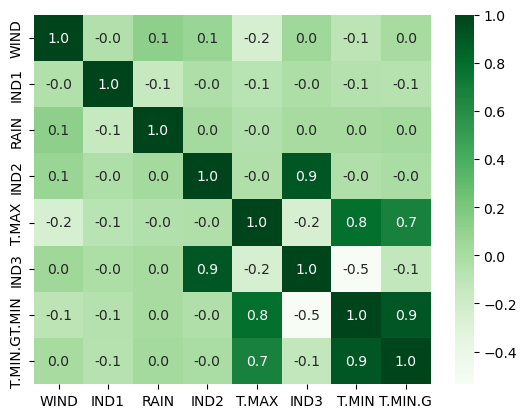

In [13]:
sns.heatmap(data.corr(), annot=True, cmap="Greens", fmt=".1f")

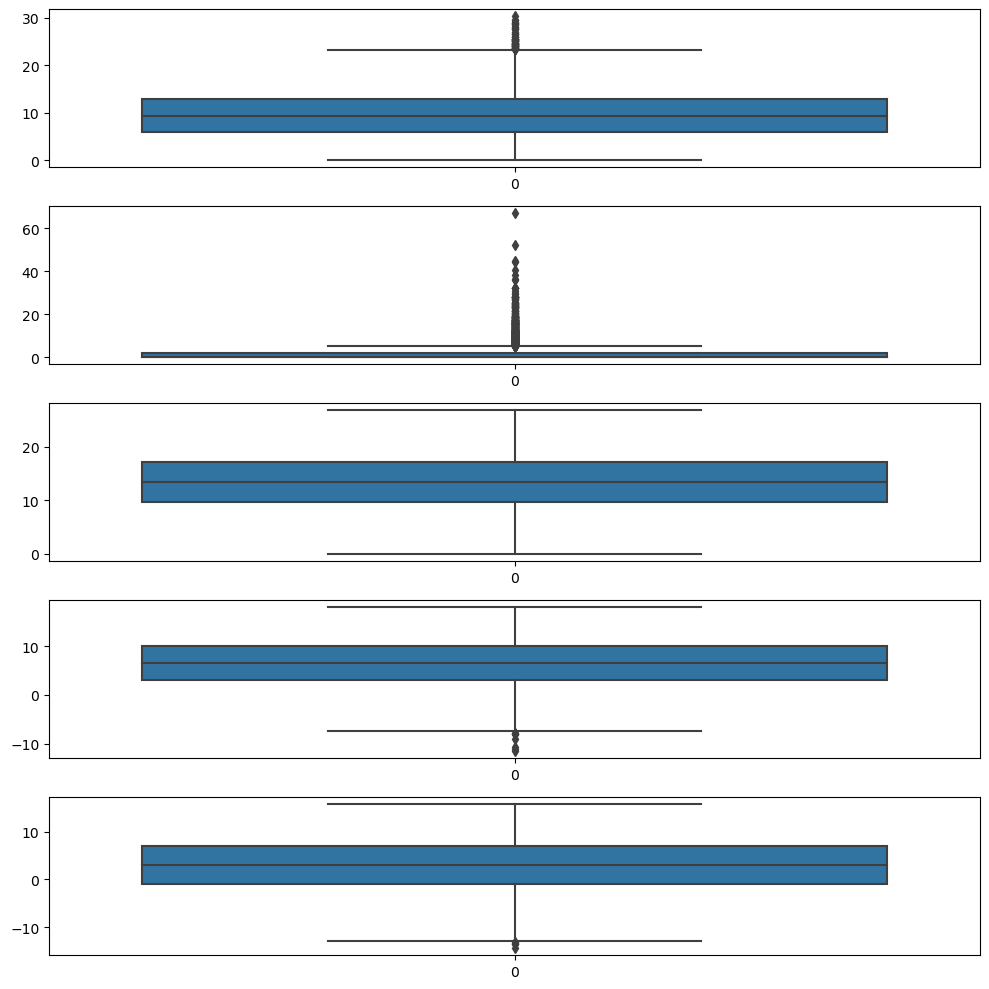

In [14]:
fig, axs = plt.subplots(5, figsize=(10, 10))
sns.boxplot(data["WIND"], ax=axs[0])
sns.boxplot(data["RAIN"], ax=axs[1])
sns.boxplot(data["T.MAX"], ax=axs[2])
sns.boxplot(data["T.MIN"], ax=axs[3])
sns.boxplot(data["T.MIN.G"], ax=axs[4])
fig.tight_layout()
plt.show()

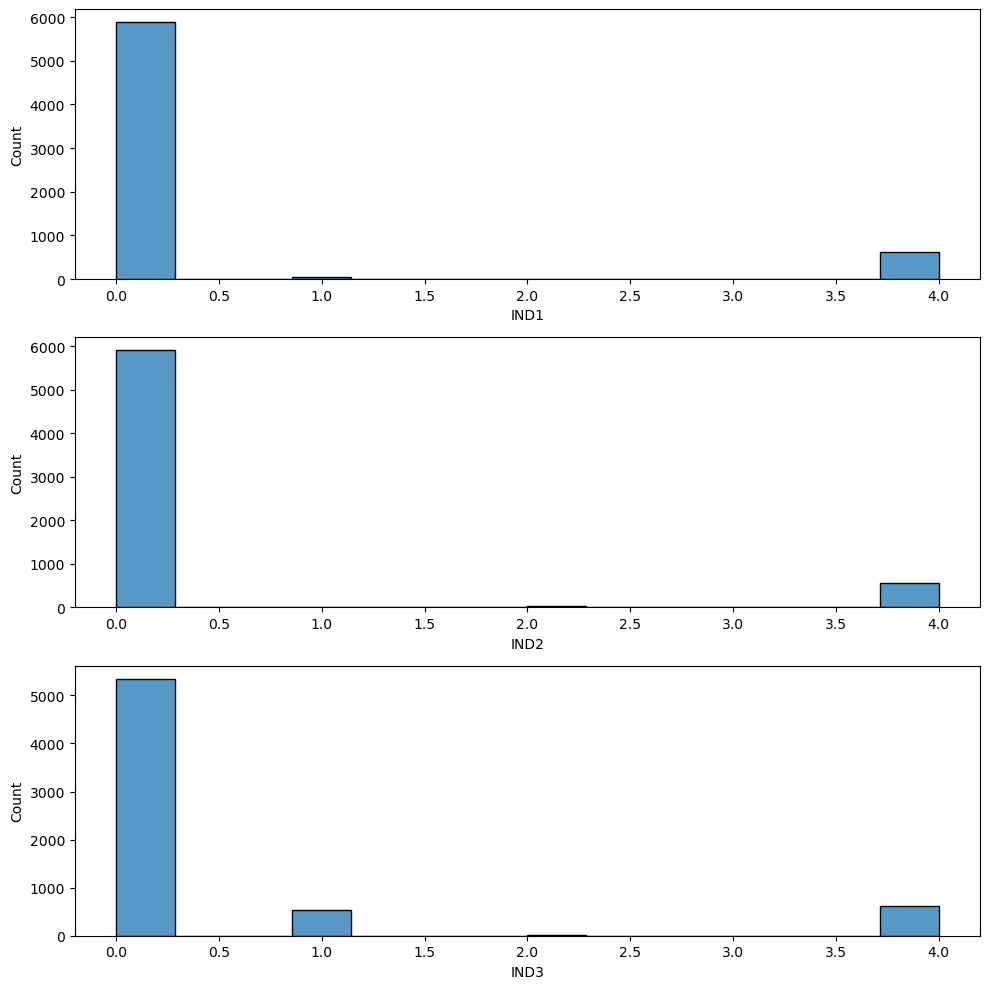

In [15]:
fig, axs = plt.subplots(3, figsize=(10, 10))
sns.histplot(data["IND1"], ax=axs[0])
sns.histplot(data["IND2"], ax=axs[1])
sns.histplot(data["IND3"], ax=axs[2])
fig.tight_layout()
plt.show()

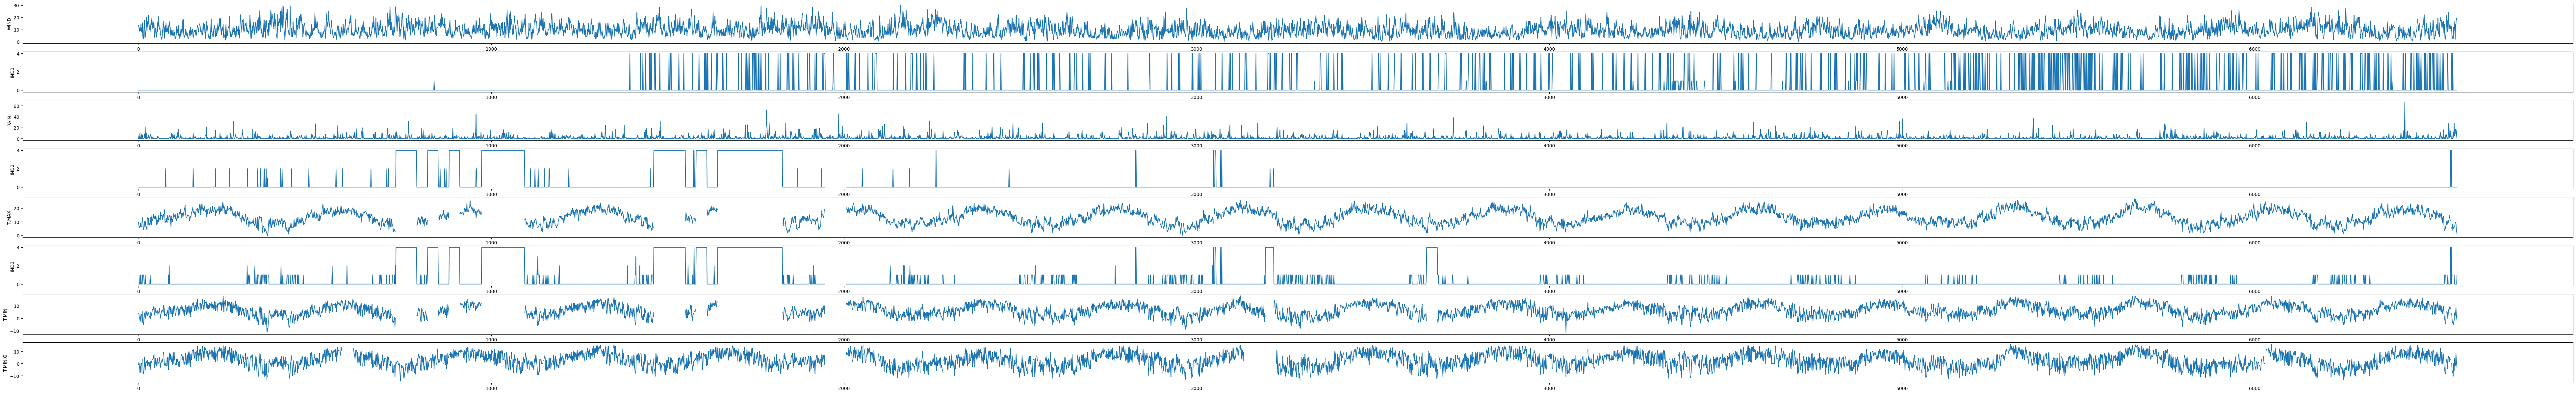

In [16]:
values = data.values

groups = [g  for g in range(8)]

i = 1

plt.figure(figsize=(100, 15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.ylabel(data.columns[group])
    i += 1
plt.show()

As features IND1, IND2 e IND3 parecem estar correlacionadas com as restantes features. Pelo plot das diferentes features, os valores de IND1, IND2 e IND3 são inteiros e parecem classificar a variação nos valores das features Temperature and IND (quando alguma desta features assume o valor NaN, o indicador correspondente assume o valor 4).

O autor do dataset foi questionado sobre o significado desta variáveis, para melhor entender o dataset, mas não se obteve resposta.


In [17]:
#dframe = data.drop(["IND1", "IND2", "IND3"], axis=1)
dframe = data.copy()

In [18]:
dframe.head()

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                            
1961-01-01  13.67     0   0.2   0.0    9.5   0.0    3.7     -1.0
1961-01-02  11.50     0   5.1   0.0    7.2   0.0    4.2      1.1
1961-01-03  11.25     0   0.4   0.0    5.5   0.0    0.5     -0.5
1961-01-04   8.63     0   0.2   0.0    5.6   0.0    0.4     -3.2
1961-01-05  11.92     0  10.4   0.0    7.2   1.0   -1.5     -7.5

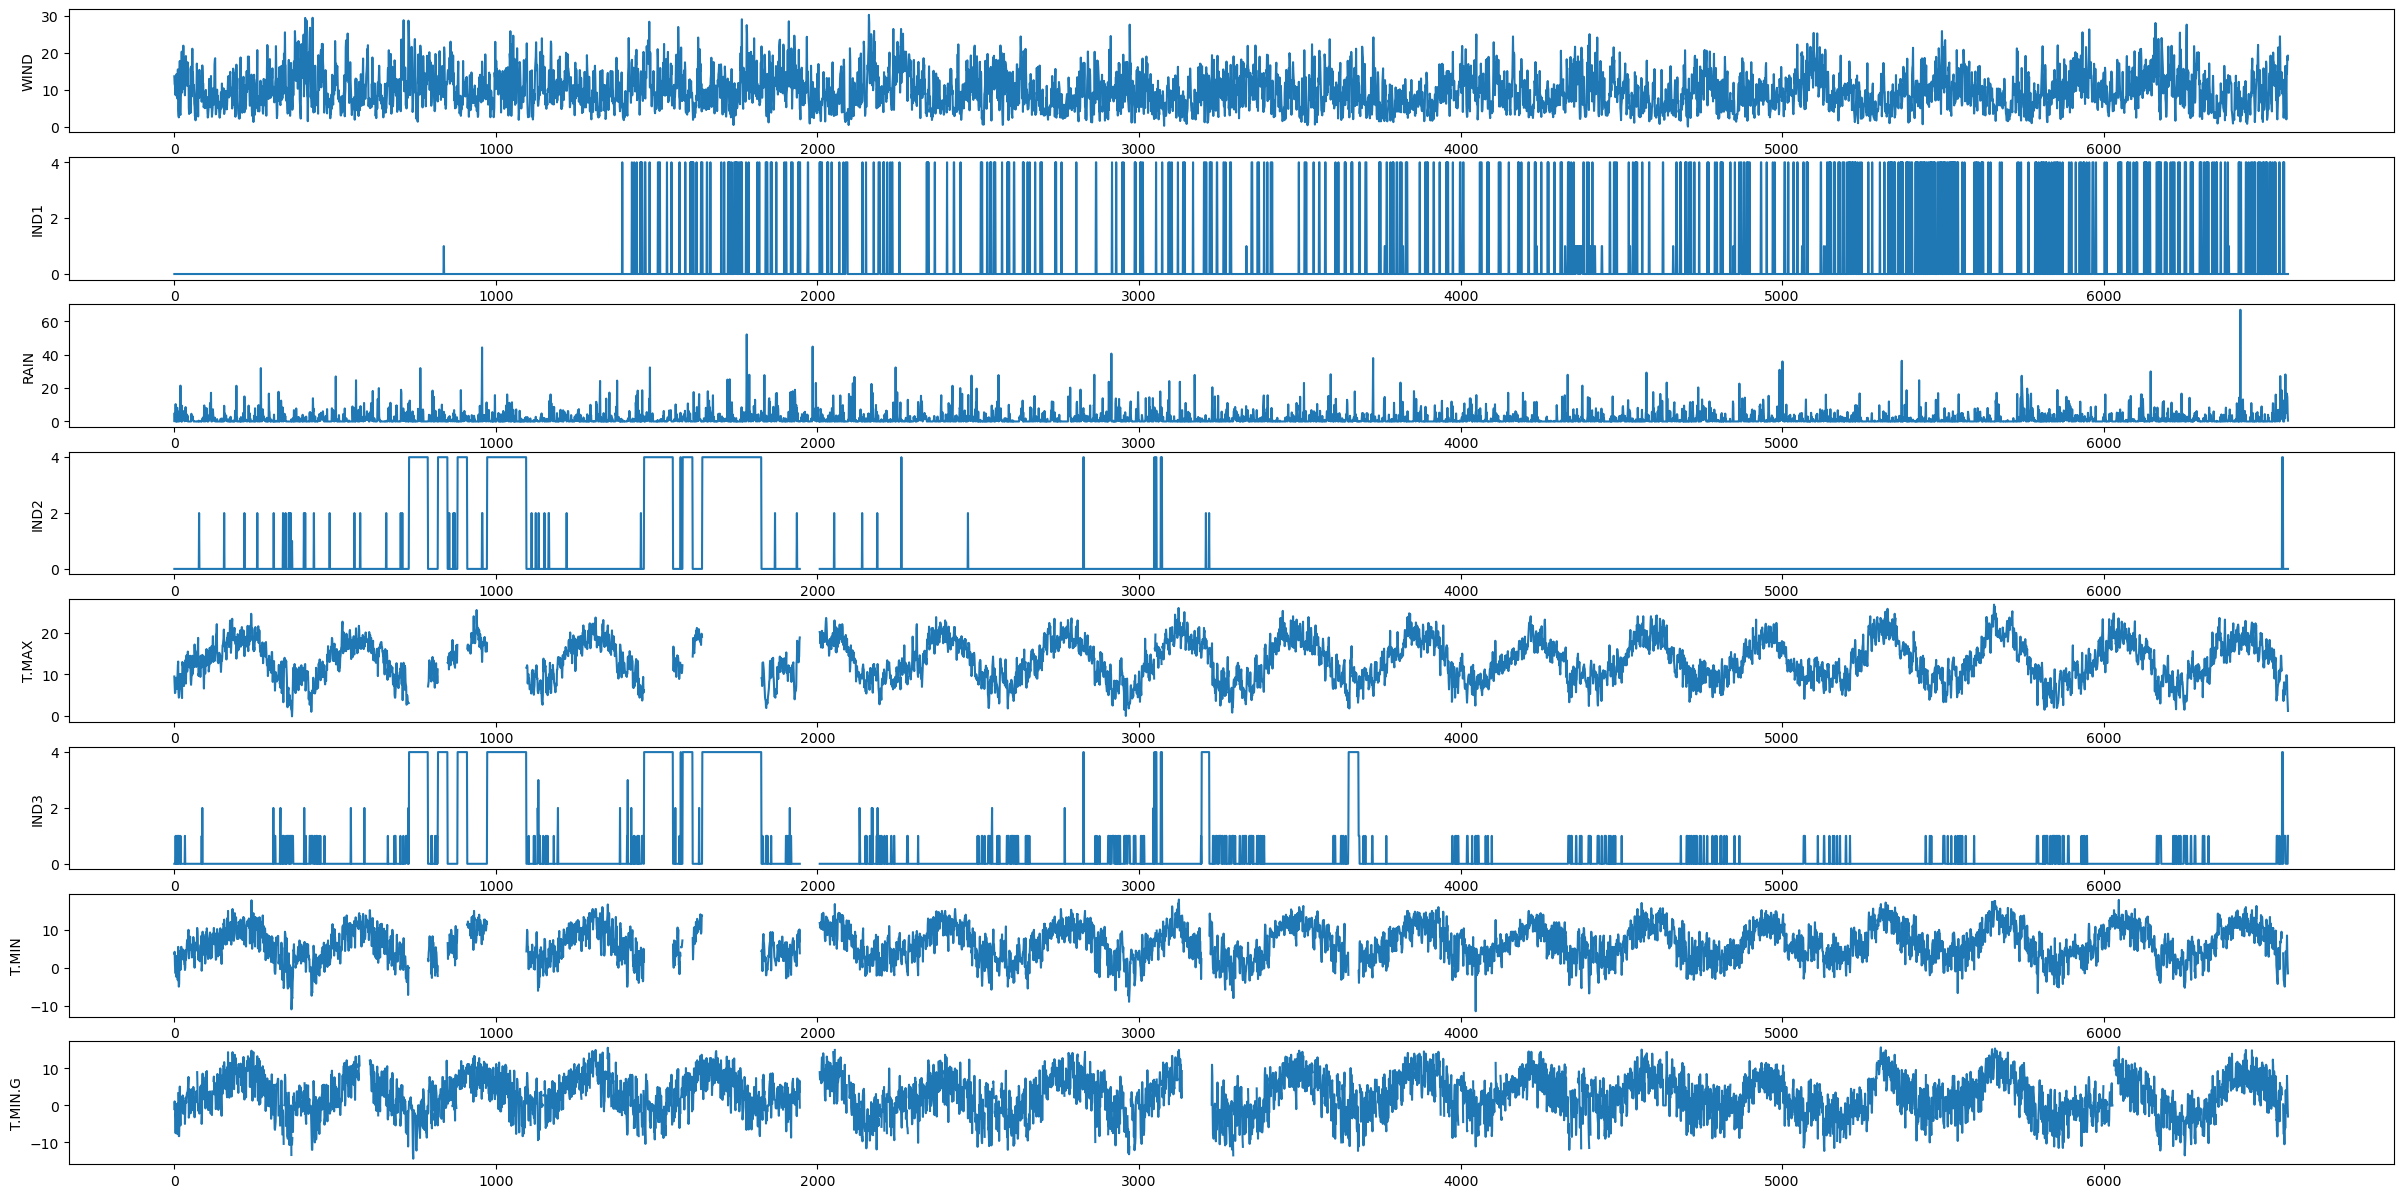

In [19]:
values = dframe.values

groups = [g  for g in range(dframe.shape[1])]

i = 1

plt.figure(figsize=(30, 15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.ylabel(dframe.columns[group])
    i += 1
plt.show()

### Deal with missing values

In [20]:
dframe

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                            
1961-01-01  13.67     0   0.2   0.0    9.5   0.0    3.7     -1.0
1961-01-02  11.50     0   5.1   0.0    7.2   0.0    4.2      1.1
1961-01-03  11.25     0   0.4   0.0    5.5   0.0    0.5     -0.5
1961-01-04   8.63     0   0.2   0.0    5.6   0.0    0.4     -3.2
1961-01-05  11.92     0  10.4   0.0    7.2   1.0   -1.5     -7.5
...           ...   ...   ...   ...    ...   ...    ...      ...
1978-12-27  14.46     0  16.8   0.0    9.8   0.0    4.0      0.0
1978-12-28  14.33     0  16.0   0.0    9.1   0.0    8.5      8.0
1978-12-29  19.17     0  14.7   0.0    5.0   0.0    3.5      3.2
1978-12-30  18.08     0   4.9   0.0    2.9   0.0    0.3     -0.5
1978-12-31  19.25     0   0.5   0.0    1.2   1.0   -1.5     -3.0

[6574 rows x 8 columns]

In [21]:
dframe.notna().value_counts()

WIND  IND1  RAIN  IND2   T.MAX  IND3   T.MIN  T.MIN.G
True  True  True  True   True   True   True   True       5638
                         False  True   False  True        543
                         True   True   True   False       260
                  False  False  False  False  False        61
                  True   True   True   False  True         31
                                              False        24
                         False  True   False  False        15
                                       True   True          2
dtype: int64

<AxesSubplot:>

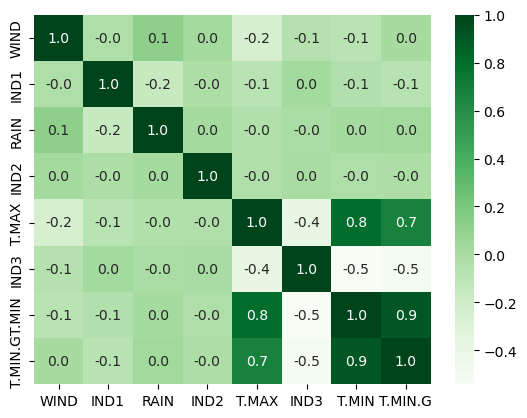

In [22]:
sns.heatmap(dframe.dropna().corr(), annot=True, cmap="Greens", fmt=".1f")

T.MAX, T.MIN e T.MIN.G são altamente correlacionadas (problema da multicolinariedade? Remover duas das três features?)

In [23]:
import miceforest as mf

In [24]:
# Create kernels. 
kernel1 = mf.ImputationKernel(
  data=dframe,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 3 iterations on each of the datasets
kernel1.mice(3,verbose=True)

Initialized logger with name mice 1-3
Dataset 0
1  | IND2 | IND3 | T.MIN.G | T.MAX | T.MIN
2  | IND2 | IND3 | T.MIN.G | T.MAX | T.MIN
3  | IND2 | IND3 | T.MIN.G | T.MAX | T.MIN


In [25]:
dframe = kernel1.complete_data(0)

In [26]:
dframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 1961-01-01 to 1978-12-31
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WIND     6574 non-null   float64
 1   IND1     6574 non-null   int64  
 2   RAIN     6574 non-null   float64
 3   IND2     6574 non-null   float64
 4   T.MAX    6574 non-null   float64
 5   IND3     6574 non-null   float64
 6   T.MIN    6574 non-null   float64
 7   T.MIN.G  6574 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 462.2 KB


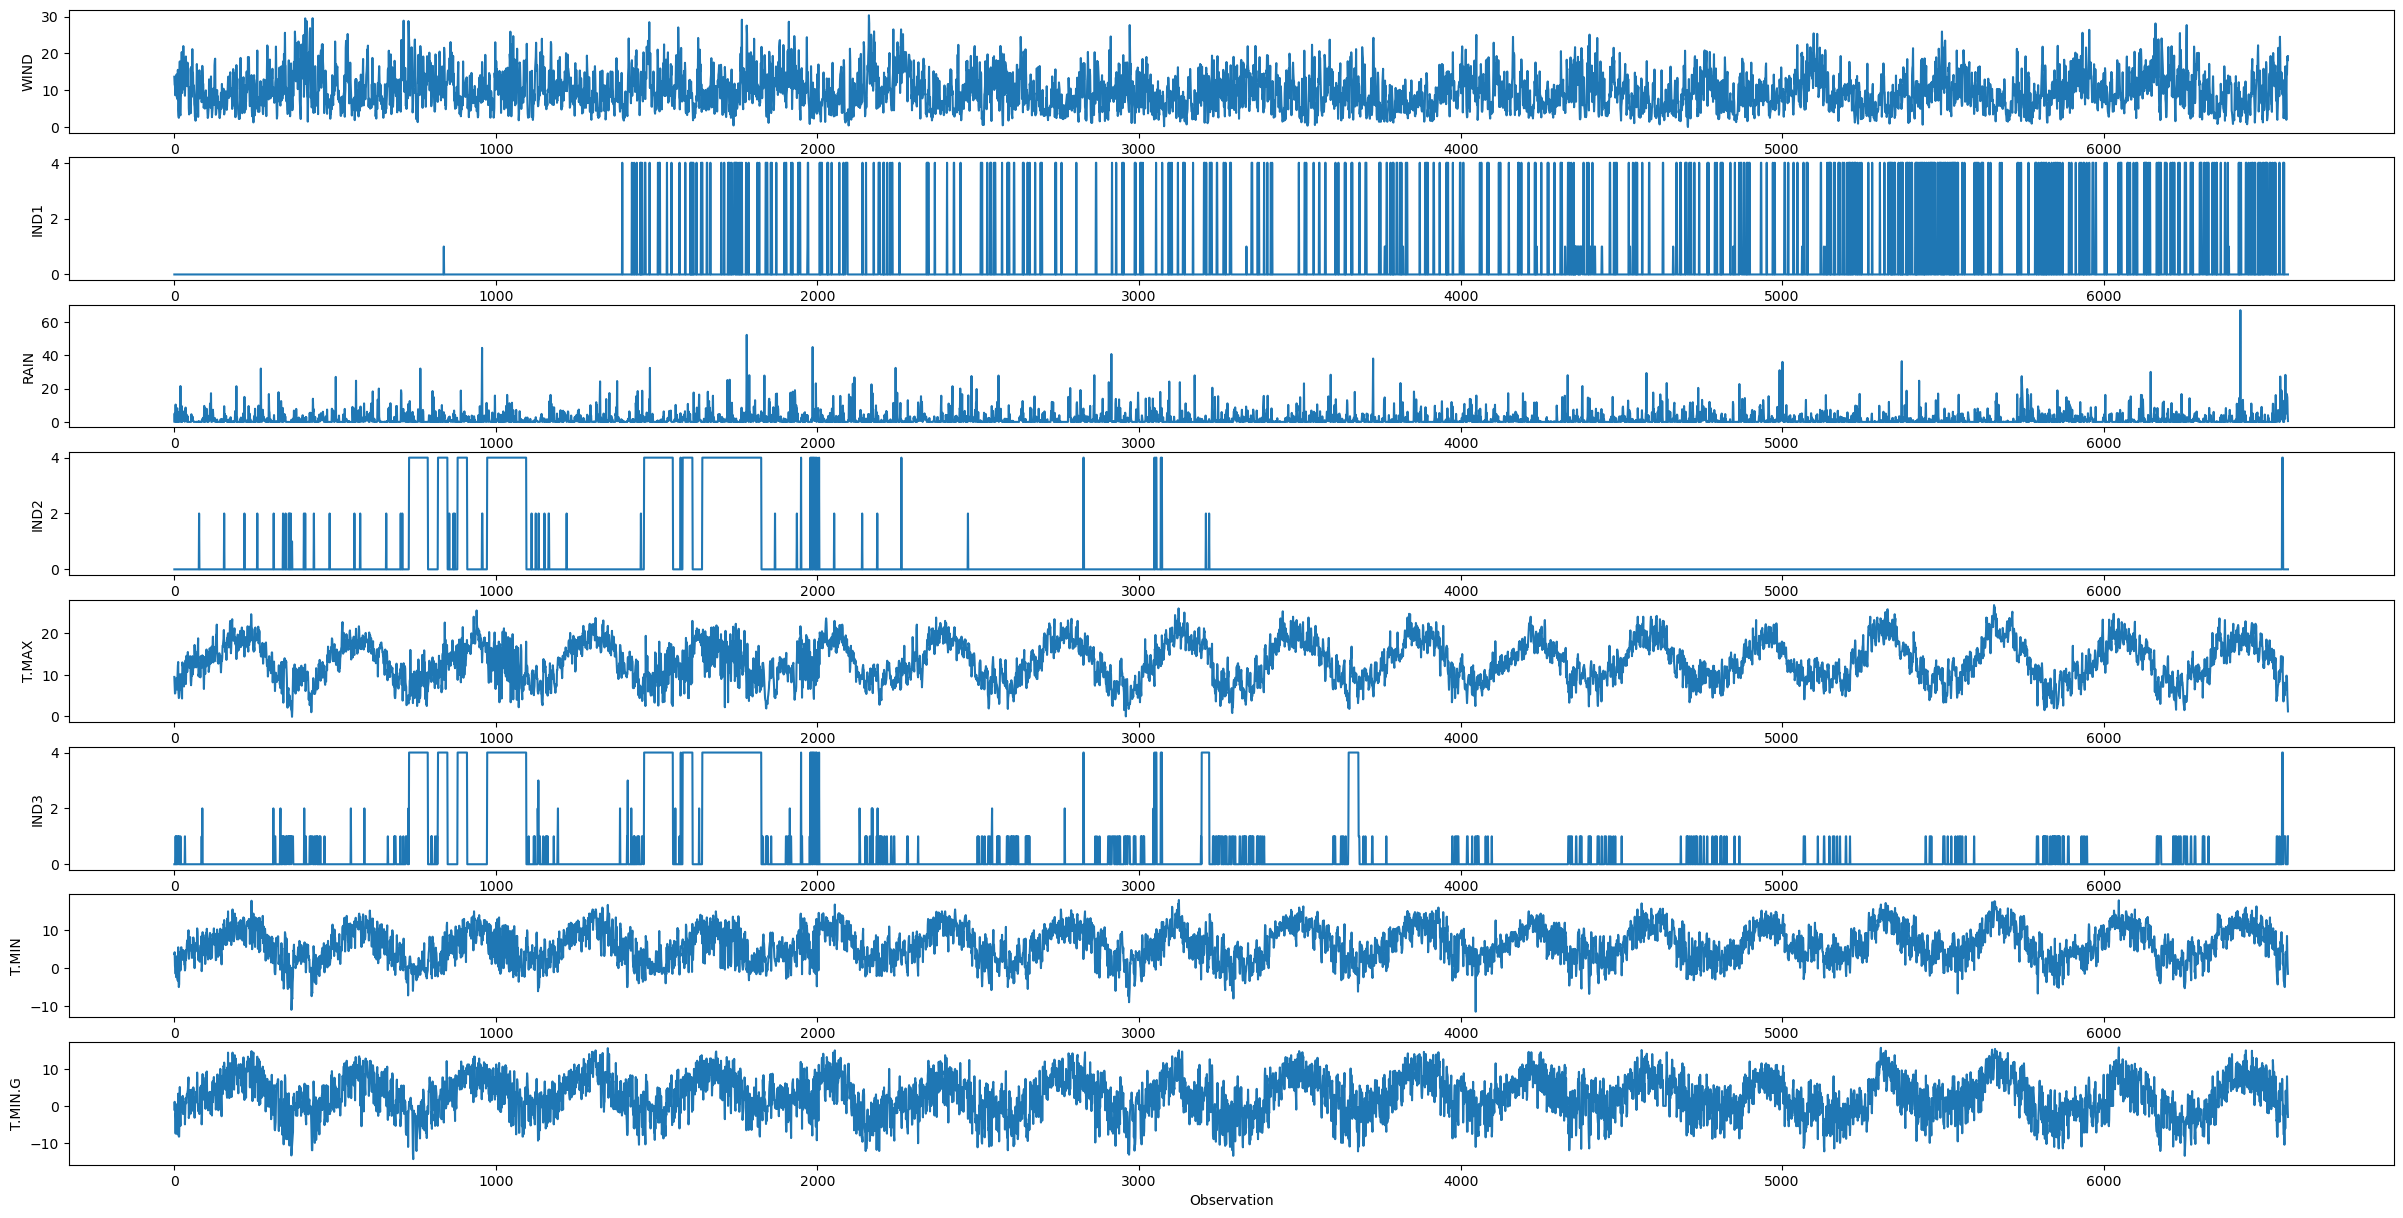

In [27]:
values = dframe.values

groups = [g  for g in range(dframe.shape[1])]

i = 1

plt.figure(figsize=(30, 15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.ylabel(dframe.columns[group])
    i += 1
plt.xlabel("Observation")
plt.show()

In [28]:
dframe.head()

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                            
1961-01-01  13.67     0   0.2   0.0    9.5   0.0    3.7     -1.0
1961-01-02  11.50     0   5.1   0.0    7.2   0.0    4.2      1.1
1961-01-03  11.25     0   0.4   0.0    5.5   0.0    0.5     -0.5
1961-01-04   8.63     0   0.2   0.0    5.6   0.0    0.4     -3.2
1961-01-05  11.92     0  10.4   0.0    7.2   1.0   -1.5     -7.5

In [29]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): 
    """
        data: data matrix
        n_in: number of input lag timesteps (hours)
        n_out: number of output prediction timesteps (hours)
 
    """
        
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)  #transforms data (pure matrix of values) into data structure adding index of rows and columns
    cols, names = list(), list()  #inicialize empty lists 
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [30]:
values.shape[0]

6574

In [31]:
values.shape[1]

8

In [32]:
from pandas import DataFrame, concat

In [33]:
list(range(53,46,-1))

[53, 52, 51, 50, 49, 48, 47]

In [34]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled =  scaler.transform(values)  #apply scaler to the values 


# specify the number of lag days. You can change this hyper-parameter
n_days = 7

# call series_to_supervised to frame data as supervised learning
reframed = series_to_supervised(scaled, n_in=n_days, n_out=1, dropnan=True)

print(reframed.head(3))

# we want to predict only the feature pm2.5 =var1(t)
# Take out the columns of var2(t), var3(t),...var8(t). The indexes below are correct if n_hours = 3
reframed.drop(reframed.columns[list(range(55,48,-1))], axis=1, inplace=True)

#Observe the difference before and after the drop step 
print(reframed.head(3))

   var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7   0.450115        0.0   0.002985        0.0   0.356877        0.0   
8   0.378663        0.0   0.076119        0.0   0.271375        0.0   
9   0.370431        0.0   0.005970        0.0   0.208178        0.0   

   var7(t-7)  var8(t-7)  var1(t-6)  var2(t-6)  ...  var7(t-1)  var8(t-1)  \
7   0.515254   0.443709   0.378663        0.0  ...   0.308475   0.241722   
8   0.532203   0.513245   0.370431        0.0  ...   0.494915   0.476821   
9   0.406780   0.460265   0.284162        0.0  ...   0.471186   0.450331   

    var1(t)  var2(t)   var3(t)  var4(t)   var5(t)  var6(t)   var7(t)   var8(t)  
7  0.470530      0.0  0.000000      0.0  0.249071      0.0  0.494915  0.476821  
8  0.264735      0.0  0.123881      0.0  0.256506      0.0  0.471186  0.450331  
9  0.376029      0.0  0.000000      0.0  0.245353      0.0  0.491525  0.493377  

[3 rows x 64 columns]
   var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(

In [35]:
values.shape

(6574, 8)

In [36]:
data.shape[0]

6574

In [37]:
data.shape[0]/365

18.01095890410959

In [38]:
18/4

4.5

In [39]:
int((data.shape[0]-round(int(data.shape[0]/365)/4))/365)

18

In [40]:
data.shape[1]

8

In [41]:
data.shape[0]*0.75

4930.5

## Split Data

First, data is split into train and test subsets. 

Then the train and test sets are split into input and output variables. 

Finally, the inputs (X) are reshaped into 3D format expected by LSTMs, namely [samples, timesteps, features].

**Total data**: 6574 samples (18 years x 365 days + 4 days (leap years)), 8 features.

**Train data**: 3D tensor(samples, timesteps, features).
4930 samples:  Data until day 1974-07-01 (75%)

**Test data**: 3D tensor (samples, timesteps, features). The rest of 1644 samples. 

In [42]:
dframe[:4930]

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                            
1961-01-01  13.67     0   0.2   0.0    9.5   0.0    3.7     -1.0
1961-01-02  11.50     0   5.1   0.0    7.2   0.0    4.2      1.1
1961-01-03  11.25     0   0.4   0.0    5.5   0.0    0.5     -0.5
1961-01-04   8.63     0   0.2   0.0    5.6   0.0    0.4     -3.2
1961-01-05  11.92     0  10.4   0.0    7.2   1.0   -1.5     -7.5
...           ...   ...   ...   ...    ...   ...    ...      ...
1974-06-27  10.29     0   0.0   0.0   14.9   0.0   11.3      8.9
1974-06-28   4.17     0   0.0   0.0   15.6   0.0   10.6      7.0
1974-06-29   3.17     0   0.9   0.0   16.8   0.0    8.6      4.2
1974-06-30   5.25     0   3.2   0.0   19.4   0.0    8.6      3.6
1974-07-01  12.96     0   1.9   0.0   18.9   0.0   10.7      7.4

[4930 rows x 8 columns]

In [43]:
m_data = values.shape[0]
n_features = values.shape[1]

In [45]:
# split into train, validation and test sets

# reframed is a structure that has not only values but also heads and row indixes. Extract only the values 
values = reframed.values
n_train_days = 4930  

#Extract training subset from values 
train = values[:n_train_days,]

#Extract test subset from values
end_val= int(n_train_days + (len(dframe)-n_train_days)/2 )
val = values[n_train_days:end_val,]
test = values[end_val:,]
# split into input and outputs

n_features =  n_features  #number of features 

n_obs = n_days * n_features  # 7*8 =56



In [46]:
values.shape

(6567, 57)

In [47]:
n_obs

56

In [48]:
train[:,1:].shape

(4930, 56)

In [49]:
n_days

7

In [50]:
n_features

8

In [51]:
train_X  = train[:,1:]   # train_X.shape = (4930, 56)
train_y = train[:,0]     # train_y.shape = (4930,)

val_X  =  val[:,:-1]     # test_X.shape = (822, 56)
val_y =  val[:,-1]       # test_y.shape = (822,)

test_X  =  test[:,:-1]   # test_X.shape = (815, 56)
test_y =  test[:,-1]     # test_y.shape = (815,)


In [52]:
print('train_X.shape={}'.format(train_X.shape))
print('val_X.shape={}'.format(val_X.shape))
print('test_X.shape={}'.format(test_X.shape))

train_X.shape=(4930, 56)
val_X.shape=(822, 56)
test_X.shape=(815, 56)


In [53]:
print('train_y.shape={}'.format(train_y.shape))
print('val_y.shape={}'.format(val_y.shape))
print('test_y.shape={}'.format(test_y.shape))

train_y.shape=(4930,)
val_y.shape=(822,)
test_y.shape=(815,)


In [54]:
# reshape input to be 3D [samples, lag_hours, features]
train_X = train_X.reshape(train_X.shape[0], n_days, n_features) # train_X.shape=(4930,7,8)
val_X =  val_X.reshape(val_X.shape[0], n_days, n_features)  # test_X.shape=(822,7,8)
test_X =  test_X.reshape(test_X.shape[0], n_days, n_features)  # test_X.shape=(815,7,8)

In [55]:
print('train_X.shape={}'.format(train_X.shape))
print('val_X.shape={}'.format(val_X.shape))
print('test_X.shape={}'.format(test_X.shape))

train_X.shape=(4930, 7, 8)
val_X.shape=(822, 7, 8)
test_X.shape=(815, 7, 8)


## Define and Fit Model

In this section, we define and fit an LSTM on the multivariate input data.
We define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting wind speed.
We use the Mean Absolute Error (MAE) loss function and the Adam version of stochastic gradient descent.
The model will be fit for 100 training epochs with batchs of size 40
At the end of the run both the training and test loss are plotted.

# 1 Layer

Epoch 1/100
155/155 - 5s - loss: 0.0291 - val_loss: 0.0490 - 5s/epoch - 30ms/step
Epoch 2/100
155/155 - 1s - loss: 0.0240 - val_loss: 0.0407 - 905ms/epoch - 6ms/step
Epoch 3/100
155/155 - 1s - loss: 0.0228 - val_loss: 0.0396 - 831ms/epoch - 5ms/step
Epoch 4/100
155/155 - 1s - loss: 0.0220 - val_loss: 0.0386 - 835ms/epoch - 5ms/step
Epoch 5/100
155/155 - 1s - loss: 0.0210 - val_loss: 0.0381 - 838ms/epoch - 5ms/step
Epoch 6/100
155/155 - 1s - loss: 0.0201 - val_loss: 0.0392 - 834ms/epoch - 5ms/step
Epoch 7/100
155/155 - 1s - loss: 0.0195 - val_loss: 0.0411 - 815ms/epoch - 5ms/step
Epoch 8/100
155/155 - 1s - loss: 0.0190 - val_loss: 0.0436 - 811ms/epoch - 5ms/step
Epoch 9/100
155/155 - 1s - loss: 0.0188 - val_loss: 0.0444 - 820ms/epoch - 5ms/step
Epoch 10/100
155/155 - 1s - loss: 0.0186 - val_loss: 0.0440 - 841ms/epoch - 5ms/step
Epoch 11/100
155/155 - 1s - loss: 0.0184 - val_loss: 0.0431 - 820ms/epoch - 5ms/step
Epoch 12/100
155/155 - 1s - loss: 0.0182 - val_loss: 0.0422 - 817ms/epoch - 

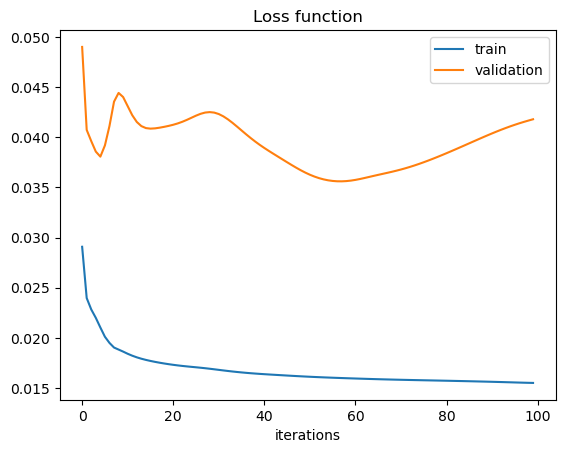

In [58]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 20
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)   ))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=32
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()
 

# 2 Layers

Epoch 1/100
155/155 - 5s - loss: 0.0573 - val_loss: 0.0988 - 5s/epoch - 31ms/step
Epoch 2/100
155/155 - 1s - loss: 0.0263 - val_loss: 0.0775 - 843ms/epoch - 5ms/step
Epoch 3/100
155/155 - 1s - loss: 0.0233 - val_loss: 0.0540 - 833ms/epoch - 5ms/step
Epoch 4/100
155/155 - 1s - loss: 0.0217 - val_loss: 0.0539 - 882ms/epoch - 6ms/step
Epoch 5/100
155/155 - 1s - loss: 0.0211 - val_loss: 0.0540 - 833ms/epoch - 5ms/step
Epoch 6/100
155/155 - 1s - loss: 0.0207 - val_loss: 0.0538 - 838ms/epoch - 5ms/step
Epoch 7/100
155/155 - 1s - loss: 0.0204 - val_loss: 0.0534 - 836ms/epoch - 5ms/step
Epoch 8/100
155/155 - 1s - loss: 0.0200 - val_loss: 0.0527 - 827ms/epoch - 5ms/step
Epoch 9/100
155/155 - 1s - loss: 0.0196 - val_loss: 0.0518 - 831ms/epoch - 5ms/step
Epoch 10/100
155/155 - 1s - loss: 0.0193 - val_loss: 0.0511 - 841ms/epoch - 5ms/step
Epoch 11/100
155/155 - 1s - loss: 0.0189 - val_loss: 0.0507 - 833ms/epoch - 5ms/step
Epoch 12/100
155/155 - 1s - loss: 0.0185 - val_loss: 0.0508 - 818ms/epoch - 

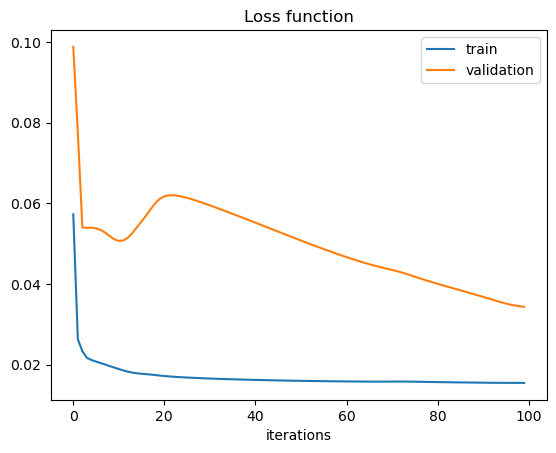

In [59]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 20
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)))
model.add(Dense(1))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=32
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

Epoch 1/100
155/155 - 5s - loss: 0.0338 - val_loss: 0.0797 - 5s/epoch - 30ms/step
Epoch 2/100
155/155 - 1s - loss: 0.0233 - val_loss: 0.0553 - 922ms/epoch - 6ms/step
Epoch 3/100
155/155 - 1s - loss: 0.0226 - val_loss: 0.0522 - 1s/epoch - 7ms/step
Epoch 4/100
155/155 - 1s - loss: 0.0223 - val_loss: 0.0508 - 1s/epoch - 7ms/step
Epoch 5/100
155/155 - 1s - loss: 0.0220 - val_loss: 0.0505 - 836ms/epoch - 5ms/step
Epoch 6/100
155/155 - 1s - loss: 0.0218 - val_loss: 0.0507 - 818ms/epoch - 5ms/step
Epoch 7/100
155/155 - 1s - loss: 0.0216 - val_loss: 0.0511 - 832ms/epoch - 5ms/step
Epoch 8/100
155/155 - 1s - loss: 0.0213 - val_loss: 0.0517 - 846ms/epoch - 5ms/step
Epoch 9/100
155/155 - 1s - loss: 0.0210 - val_loss: 0.0522 - 831ms/epoch - 5ms/step
Epoch 10/100
155/155 - 1s - loss: 0.0208 - val_loss: 0.0527 - 891ms/epoch - 6ms/step
Epoch 11/100
155/155 - 1s - loss: 0.0205 - val_loss: 0.0532 - 903ms/epoch - 6ms/step
Epoch 12/100
155/155 - 1s - loss: 0.0202 - val_loss: 0.0539 - 892ms/epoch - 6ms/st

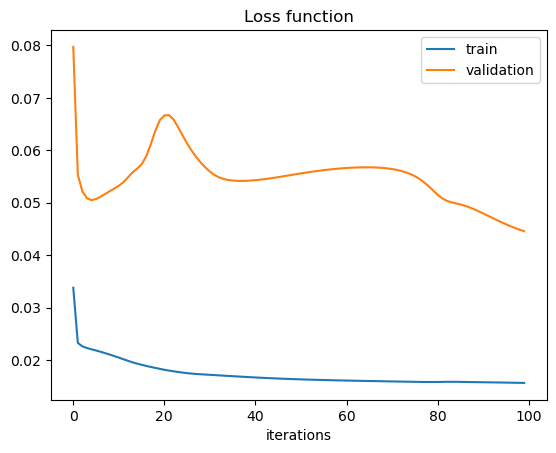

In [65]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 20
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)))
model.add(Dense(15))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=32
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

Epoch 1/100
155/155 - 5s - loss: 0.0512 - val_loss: 0.0564 - 5s/epoch - 31ms/step
Epoch 2/100
155/155 - 1s - loss: 0.0251 - val_loss: 0.0448 - 845ms/epoch - 5ms/step
Epoch 3/100
155/155 - 1s - loss: 0.0237 - val_loss: 0.0399 - 829ms/epoch - 5ms/step
Epoch 4/100
155/155 - 1s - loss: 0.0232 - val_loss: 0.0433 - 821ms/epoch - 5ms/step
Epoch 5/100
155/155 - 1s - loss: 0.0228 - val_loss: 0.0468 - 898ms/epoch - 6ms/step
Epoch 6/100
155/155 - 1s - loss: 0.0224 - val_loss: 0.0500 - 868ms/epoch - 6ms/step
Epoch 7/100
155/155 - 1s - loss: 0.0221 - val_loss: 0.0526 - 823ms/epoch - 5ms/step
Epoch 8/100
155/155 - 1s - loss: 0.0217 - val_loss: 0.0542 - 802ms/epoch - 5ms/step
Epoch 9/100
155/155 - 1s - loss: 0.0213 - val_loss: 0.0548 - 803ms/epoch - 5ms/step
Epoch 10/100
155/155 - 1s - loss: 0.0210 - val_loss: 0.0544 - 791ms/epoch - 5ms/step
Epoch 11/100
155/155 - 1s - loss: 0.0206 - val_loss: 0.0534 - 811ms/epoch - 5ms/step
Epoch 12/100
155/155 - 1s - loss: 0.0202 - val_loss: 0.0522 - 796ms/epoch - 

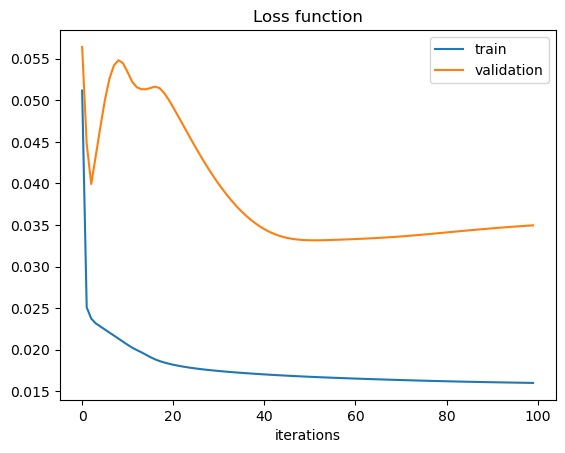

In [70]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 10
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)))
model.add(Dense(15))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=32
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

Epoch 1/100
155/155 - 5s - loss: 0.0602 - val_loss: 0.0351 - 5s/epoch - 29ms/step
Epoch 2/100
155/155 - 1s - loss: 0.0258 - val_loss: 0.0422 - 806ms/epoch - 5ms/step
Epoch 3/100
155/155 - 1s - loss: 0.0249 - val_loss: 0.0451 - 787ms/epoch - 5ms/step
Epoch 4/100
155/155 - 1s - loss: 0.0245 - val_loss: 0.0466 - 799ms/epoch - 5ms/step
Epoch 5/100
155/155 - 1s - loss: 0.0243 - val_loss: 0.0479 - 764ms/epoch - 5ms/step
Epoch 6/100
155/155 - 1s - loss: 0.0241 - val_loss: 0.0495 - 760ms/epoch - 5ms/step
Epoch 7/100
155/155 - 1s - loss: 0.0239 - val_loss: 0.0515 - 773ms/epoch - 5ms/step
Epoch 8/100
155/155 - 1s - loss: 0.0238 - val_loss: 0.0537 - 780ms/epoch - 5ms/step
Epoch 9/100
155/155 - 1s - loss: 0.0236 - val_loss: 0.0563 - 774ms/epoch - 5ms/step
Epoch 10/100
155/155 - 1s - loss: 0.0234 - val_loss: 0.0591 - 765ms/epoch - 5ms/step
Epoch 11/100
155/155 - 1s - loss: 0.0233 - val_loss: 0.0622 - 772ms/epoch - 5ms/step
Epoch 12/100
155/155 - 1s - loss: 0.0231 - val_loss: 0.0655 - 789ms/epoch - 

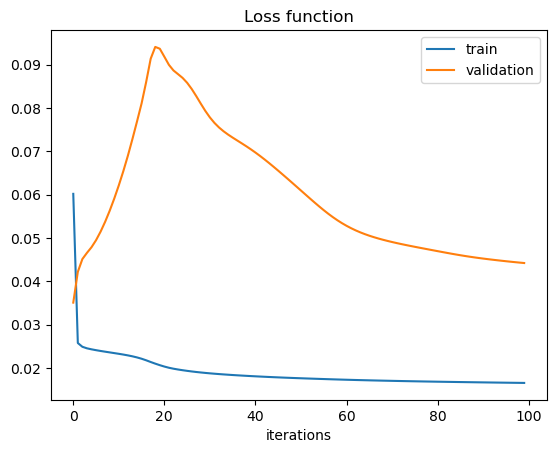

In [71]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 5
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)))
model.add(Dense(15))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=32
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

Epoch 1/100
124/124 - 6s - loss: 0.0438 - val_loss: 0.1187 - 6s/epoch - 46ms/step
Epoch 2/100
124/124 - 1s - loss: 0.0266 - val_loss: 0.0669 - 713ms/epoch - 6ms/step
Epoch 3/100
124/124 - 1s - loss: 0.0245 - val_loss: 0.0475 - 753ms/epoch - 6ms/step
Epoch 4/100
124/124 - 1s - loss: 0.0239 - val_loss: 0.0474 - 789ms/epoch - 6ms/step
Epoch 5/100
124/124 - 1s - loss: 0.0236 - val_loss: 0.0499 - 695ms/epoch - 6ms/step
Epoch 6/100
124/124 - 1s - loss: 0.0234 - val_loss: 0.0526 - 816ms/epoch - 7ms/step
Epoch 7/100
124/124 - 1s - loss: 0.0231 - val_loss: 0.0554 - 731ms/epoch - 6ms/step
Epoch 8/100
124/124 - 1s - loss: 0.0229 - val_loss: 0.0584 - 720ms/epoch - 6ms/step
Epoch 9/100
124/124 - 1s - loss: 0.0226 - val_loss: 0.0618 - 670ms/epoch - 5ms/step
Epoch 10/100
124/124 - 1s - loss: 0.0222 - val_loss: 0.0654 - 697ms/epoch - 6ms/step
Epoch 11/100
124/124 - 1s - loss: 0.0219 - val_loss: 0.0682 - 655ms/epoch - 5ms/step
Epoch 12/100
124/124 - 1s - loss: 0.0215 - val_loss: 0.0694 - 672ms/epoch - 

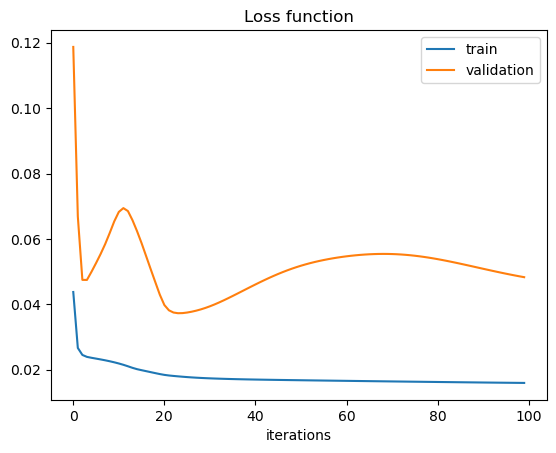

In [72]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 10
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)))
model.add(Dense(15))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=40
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

Epoch 1/100
206/206 - 6s - loss: 0.0309 - val_loss: 0.0506 - 6s/epoch - 27ms/step
Epoch 2/100
206/206 - 2s - loss: 0.0263 - val_loss: 0.0329 - 2s/epoch - 8ms/step
Epoch 3/100
206/206 - 1s - loss: 0.0245 - val_loss: 0.0289 - 1s/epoch - 7ms/step
Epoch 4/100
206/206 - 1s - loss: 0.0239 - val_loss: 0.0294 - 1s/epoch - 6ms/step
Epoch 5/100
206/206 - 1s - loss: 0.0233 - val_loss: 0.0300 - 1s/epoch - 6ms/step
Epoch 6/100
206/206 - 1s - loss: 0.0228 - val_loss: 0.0306 - 1s/epoch - 6ms/step
Epoch 7/100
206/206 - 1s - loss: 0.0223 - val_loss: 0.0312 - 1s/epoch - 6ms/step
Epoch 8/100
206/206 - 2s - loss: 0.0219 - val_loss: 0.0316 - 2s/epoch - 8ms/step
Epoch 9/100
206/206 - 1s - loss: 0.0215 - val_loss: 0.0320 - 1s/epoch - 5ms/step
Epoch 10/100
206/206 - 1s - loss: 0.0211 - val_loss: 0.0322 - 1s/epoch - 6ms/step
Epoch 11/100
206/206 - 1s - loss: 0.0208 - val_loss: 0.0322 - 1s/epoch - 6ms/step
Epoch 12/100
206/206 - 1s - loss: 0.0205 - val_loss: 0.0322 - 1s/epoch - 7ms/step
Epoch 13/100
206/206 - 1

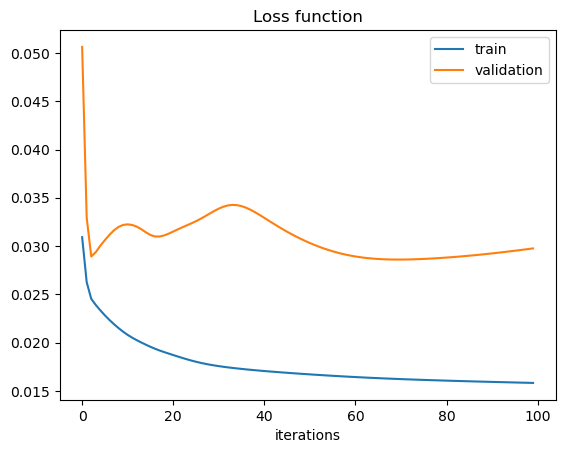

In [73]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 10
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)))
model.add(Dense(15))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=24
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

Epoch 1/100
309/309 - 6s - loss: 0.0266 - val_loss: 0.0359 - 6s/epoch - 18ms/step
Epoch 2/100
309/309 - 2s - loss: 0.0239 - val_loss: 0.0429 - 2s/epoch - 5ms/step
Epoch 3/100
309/309 - 2s - loss: 0.0234 - val_loss: 0.0494 - 2s/epoch - 6ms/step
Epoch 4/100
309/309 - 2s - loss: 0.0230 - val_loss: 0.0550 - 2s/epoch - 6ms/step
Epoch 5/100
309/309 - 2s - loss: 0.0226 - val_loss: 0.0596 - 2s/epoch - 6ms/step
Epoch 6/100
309/309 - 2s - loss: 0.0221 - val_loss: 0.0630 - 2s/epoch - 6ms/step
Epoch 7/100
309/309 - 2s - loss: 0.0217 - val_loss: 0.0651 - 2s/epoch - 5ms/step
Epoch 8/100
309/309 - 2s - loss: 0.0213 - val_loss: 0.0661 - 2s/epoch - 5ms/step
Epoch 9/100
309/309 - 2s - loss: 0.0209 - val_loss: 0.0663 - 2s/epoch - 5ms/step
Epoch 10/100
309/309 - 2s - loss: 0.0206 - val_loss: 0.0658 - 2s/epoch - 5ms/step
Epoch 11/100
309/309 - 2s - loss: 0.0202 - val_loss: 0.0646 - 2s/epoch - 6ms/step
Epoch 12/100
309/309 - 2s - loss: 0.0199 - val_loss: 0.0631 - 2s/epoch - 7ms/step
Epoch 13/100
309/309 - 2

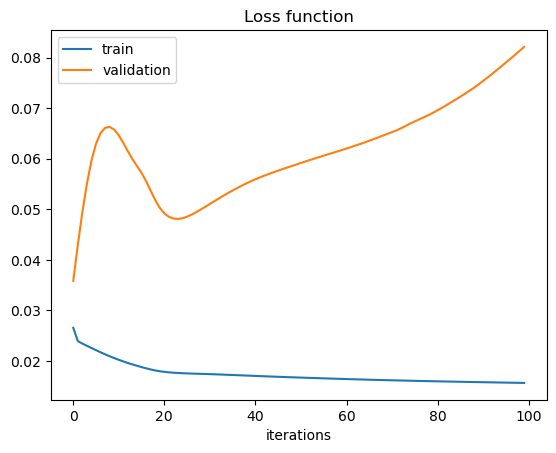

In [74]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 10
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)))
model.add(Dense(15))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=16
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

Epoch 1/100
155/155 - 9s - loss: 0.0309 - val_loss: 0.0660 - 9s/epoch - 56ms/step
Epoch 2/100
155/155 - 2s - loss: 0.0224 - val_loss: 0.0423 - 2s/epoch - 10ms/step
Epoch 3/100
155/155 - 2s - loss: 0.0216 - val_loss: 0.0402 - 2s/epoch - 10ms/step
Epoch 4/100
155/155 - 2s - loss: 0.0210 - val_loss: 0.0384 - 2s/epoch - 10ms/step
Epoch 5/100
155/155 - 2s - loss: 0.0205 - val_loss: 0.0386 - 2s/epoch - 10ms/step
Epoch 6/100
155/155 - 1s - loss: 0.0201 - val_loss: 0.0398 - 1s/epoch - 10ms/step
Epoch 7/100
155/155 - 2s - loss: 0.0196 - val_loss: 0.0405 - 2s/epoch - 10ms/step
Epoch 8/100
155/155 - 2s - loss: 0.0192 - val_loss: 0.0413 - 2s/epoch - 10ms/step
Epoch 9/100
155/155 - 2s - loss: 0.0189 - val_loss: 0.0425 - 2s/epoch - 10ms/step
Epoch 10/100
155/155 - 1s - loss: 0.0185 - val_loss: 0.0440 - 1s/epoch - 10ms/step
Epoch 11/100
155/155 - 2s - loss: 0.0182 - val_loss: 0.0450 - 2s/epoch - 11ms/step
Epoch 12/100
155/155 - 2s - loss: 0.0180 - val_loss: 0.0447 - 2s/epoch - 10ms/step
Epoch 13/100


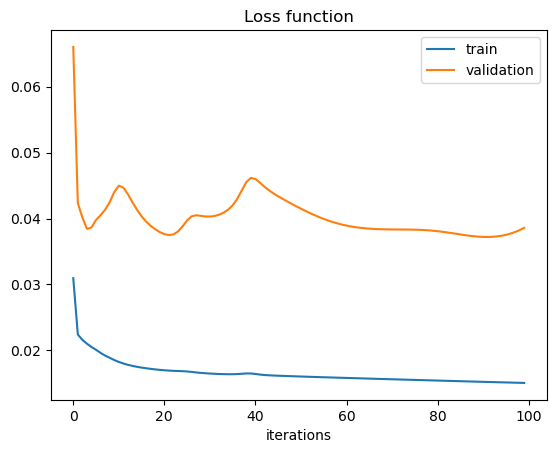

In [75]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 20
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features), return_sequences=True))
model.add(LSTM(n_neurons))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=32
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

# 3 Layers

Epoch 1/100
155/155 - 5s - loss: 0.0482 - val_loss: 0.1530 - 5s/epoch - 34ms/step
Epoch 2/100
155/155 - 1s - loss: 0.0298 - val_loss: 0.1155 - 907ms/epoch - 6ms/step
Epoch 3/100
155/155 - 1s - loss: 0.0266 - val_loss: 0.0842 - 884ms/epoch - 6ms/step
Epoch 4/100
155/155 - 1s - loss: 0.0256 - val_loss: 0.0729 - 915ms/epoch - 6ms/step
Epoch 5/100
155/155 - 1s - loss: 0.0253 - val_loss: 0.0697 - 930ms/epoch - 6ms/step
Epoch 6/100
155/155 - 1s - loss: 0.0252 - val_loss: 0.0682 - 904ms/epoch - 6ms/step
Epoch 7/100
155/155 - 1s - loss: 0.0251 - val_loss: 0.0671 - 887ms/epoch - 6ms/step
Epoch 8/100
155/155 - 1s - loss: 0.0250 - val_loss: 0.0663 - 882ms/epoch - 6ms/step
Epoch 9/100
155/155 - 1s - loss: 0.0250 - val_loss: 0.0657 - 935ms/epoch - 6ms/step
Epoch 10/100
155/155 - 1s - loss: 0.0249 - val_loss: 0.0651 - 1s/epoch - 7ms/step
Epoch 11/100
155/155 - 1s - loss: 0.0249 - val_loss: 0.0646 - 1s/epoch - 7ms/step
Epoch 12/100
155/155 - 1s - loss: 0.0249 - val_loss: 0.0642 - 934ms/epoch - 6ms/st

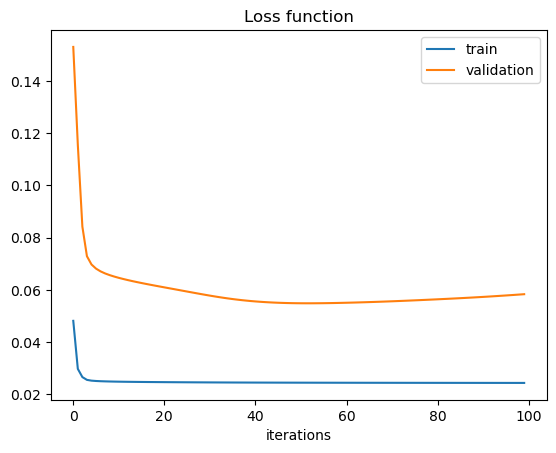

In [67]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 20
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features), return_sequences=True))
model.add(Dense(1))
model.add(Dense(1))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=32
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

Epoch 1/100
155/155 - 8s - loss: 0.0336 - val_loss: 0.0981 - 8s/epoch - 54ms/step
Epoch 2/100
155/155 - 2s - loss: 0.0240 - val_loss: 0.0393 - 2s/epoch - 10ms/step
Epoch 3/100
155/155 - 2s - loss: 0.0217 - val_loss: 0.0389 - 2s/epoch - 10ms/step
Epoch 4/100
155/155 - 2s - loss: 0.0211 - val_loss: 0.0392 - 2s/epoch - 10ms/step
Epoch 5/100
155/155 - 2s - loss: 0.0206 - val_loss: 0.0394 - 2s/epoch - 10ms/step
Epoch 6/100
155/155 - 2s - loss: 0.0202 - val_loss: 0.0388 - 2s/epoch - 10ms/step
Epoch 7/100
155/155 - 2s - loss: 0.0198 - val_loss: 0.0376 - 2s/epoch - 10ms/step
Epoch 8/100
155/155 - 1s - loss: 0.0194 - val_loss: 0.0360 - 1s/epoch - 10ms/step
Epoch 9/100
155/155 - 2s - loss: 0.0191 - val_loss: 0.0342 - 2s/epoch - 10ms/step
Epoch 10/100
155/155 - 1s - loss: 0.0188 - val_loss: 0.0327 - 1s/epoch - 9ms/step
Epoch 11/100
155/155 - 1s - loss: 0.0185 - val_loss: 0.0317 - 1s/epoch - 9ms/step
Epoch 12/100
155/155 - 1s - loss: 0.0182 - val_loss: 0.0311 - 1s/epoch - 10ms/step
Epoch 13/100
15

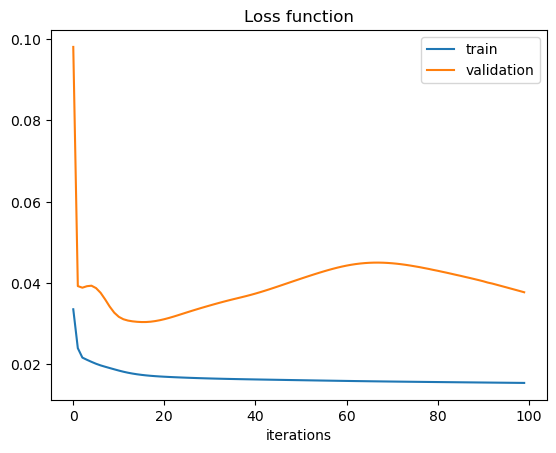

In [61]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 20
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features), return_sequences=True))
model.add(Dense(1))
model.add(LSTM(n_neurons))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=32
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

Epoch 1/100
155/155 - 9s - loss: 0.0322 - val_loss: 0.0430 - 9s/epoch - 57ms/step
Epoch 2/100
155/155 - 2s - loss: 0.0225 - val_loss: 0.0388 - 2s/epoch - 11ms/step
Epoch 3/100
155/155 - 1s - loss: 0.0218 - val_loss: 0.0379 - 1s/epoch - 10ms/step
Epoch 4/100
155/155 - 2s - loss: 0.0212 - val_loss: 0.0368 - 2s/epoch - 10ms/step
Epoch 5/100
155/155 - 2s - loss: 0.0208 - val_loss: 0.0359 - 2s/epoch - 10ms/step
Epoch 6/100
155/155 - 1s - loss: 0.0204 - val_loss: 0.0358 - 1s/epoch - 10ms/step
Epoch 7/100
155/155 - 1s - loss: 0.0200 - val_loss: 0.0360 - 1s/epoch - 10ms/step
Epoch 8/100
155/155 - 2s - loss: 0.0195 - val_loss: 0.0369 - 2s/epoch - 10ms/step
Epoch 9/100
155/155 - 2s - loss: 0.0190 - val_loss: 0.0383 - 2s/epoch - 10ms/step
Epoch 10/100
155/155 - 2s - loss: 0.0187 - val_loss: 0.0391 - 2s/epoch - 10ms/step
Epoch 11/100
155/155 - 2s - loss: 0.0184 - val_loss: 0.0397 - 2s/epoch - 10ms/step
Epoch 12/100
155/155 - 1s - loss: 0.0182 - val_loss: 0.0400 - 1s/epoch - 9ms/step
Epoch 13/100
1

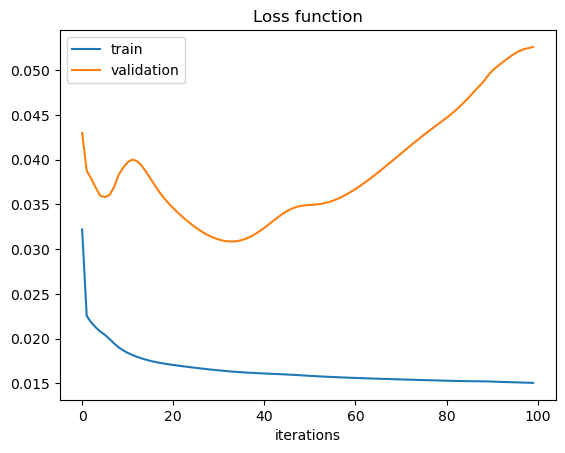

In [66]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 20
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features), return_sequences=True))
model.add(Dense(15))
model.add(LSTM(n_neurons))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=32
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

### Best option

Epoch 1/100
206/206 - 5s - loss: 0.0302 - val_loss: 0.0820 - 5s/epoch - 25ms/step
Epoch 2/100
206/206 - 1s - loss: 0.0246 - val_loss: 0.0673 - 1s/epoch - 6ms/step
Epoch 3/100
206/206 - 1s - loss: 0.0237 - val_loss: 0.0665 - 1s/epoch - 5ms/step
Epoch 4/100
206/206 - 1s - loss: 0.0233 - val_loss: 0.0660 - 1s/epoch - 6ms/step
Epoch 5/100
206/206 - 1s - loss: 0.0229 - val_loss: 0.0655 - 1s/epoch - 5ms/step
Epoch 6/100
206/206 - 1s - loss: 0.0226 - val_loss: 0.0650 - 1s/epoch - 6ms/step
Epoch 7/100
206/206 - 1s - loss: 0.0223 - val_loss: 0.0649 - 1s/epoch - 6ms/step
Epoch 8/100
206/206 - 1s - loss: 0.0219 - val_loss: 0.0651 - 1s/epoch - 6ms/step
Epoch 9/100
206/206 - 1s - loss: 0.0216 - val_loss: 0.0644 - 1s/epoch - 6ms/step
Epoch 10/100
206/206 - 1s - loss: 0.0212 - val_loss: 0.0622 - 1s/epoch - 6ms/step
Epoch 11/100
206/206 - 1s - loss: 0.0208 - val_loss: 0.0596 - 1s/epoch - 7ms/step
Epoch 12/100
206/206 - 1s - loss: 0.0204 - val_loss: 0.0582 - 1s/epoch - 5ms/step
Epoch 13/100
206/206 - 1

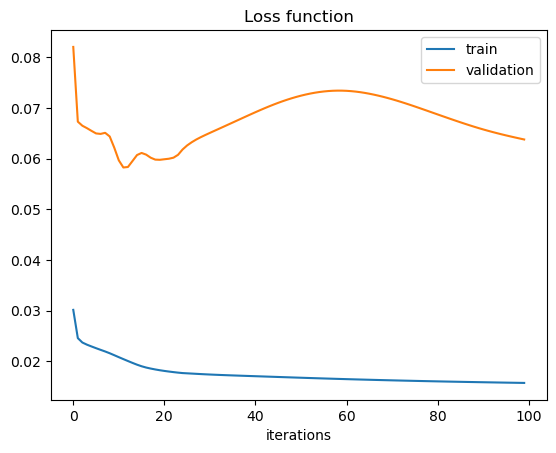

In [77]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 10
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)))
model.add(Dense(15))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mse', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=24
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

In [ ]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 10
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)   ))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mae', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=40
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

In [ ]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 5
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)   ))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mae', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=40
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

In [ ]:
# Sequential model is appropriate to design LSTM RNN
model = Sequential()
# train_X : 3D tensor (samples, lag_hours, feature)
n_neurons = 5
# single input_shape = (lag_days, feature)
model.add(LSTM(n_neurons, input_shape=(n_days, n_features)   ))
model.add(Dense(1))  # 1 neuron in the output layer
model.compile(loss='mae', optimizer='adam')

# fit network
#verbose=0 will show nothing (silent)
#verbose=1 will show an animated progress bar
#verbose=2 will show the training progress for each epoch (shows loss and val_loss)
n_epochs=100
batch_size=16
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False)

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'validation'])
plt.xlabel('iterations')
plt.show()

## Evaluate Model
After the model is fit, we can forecast for the test dataset.
Compute the error as the Root Mean Squared Error (RMSE). 

Compare the predictions and the real data

In [ ]:
ytest=test_y.reshape(test_y.shape[0], 1)

In [ ]:
yhat = model.predict(test_X) 

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
plt.plot(test_y, color='red', label='real data')

plt.plot(yhat, color='blue', label='predictions')
plt.legend()